In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms as T

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = 224
weight_path = "./save_weights/best_clf_f88_k35_weights.pt"
class_names = ['christmas tree', 'grinch', 'reindeer', 'santa', 'snowman']

In [3]:
def to_tensor(image_path: str) :
    transformer = T.Compose([T.Resize((IMAGE_SIZE, IMAGE_SIZE))])
    image = torchvision.io.read_image(image_path).type(torch.float32) / 255.
    image_transform = transformer(image)
    return image_transform.to(device)

def predict(image_tensor, model) :
    model.eval()
    with torch.inference_mode() :
        predict, y, z = model(image_tensor.reshape(1, 3, IMAGE_SIZE, IMAGE_SIZE)) # add batch
        probas = F.softmax(predict)
        predict_idx = torch.argmax(probas)
        predict_class = class_names[predict_idx]
    return predict_class, probas.detach().cpu().numpy(), y, z

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, f1, f2, k1, k2, flatten_num, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, f1, kernel_size=k1, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(f1, f2, kernel_size=k2, stride=1, padding=1)
        self.fc1 = nn.Linear(flatten_num, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        y = self.relu(x)
        x = self.pool(y)
        x = self.conv2(x)
        z = self.relu(x)
        x = self.pool(z)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x, y, z

In [5]:
model = SimpleCNN(8, 8, 3, 5, 24200, num_classes=len(class_names)).to(device)
model.load_state_dict(torch.load(weight_path, map_location=device))

<All keys matched successfully>

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
count_parameters(model)

122837

c:\Users\alant\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
C:\Users\alant\AppData\Local\Temp\ipykernel_13416\2095096526.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probas = F.softmax(predict)


(-0.5, 109.5, 109.5, -0.5)

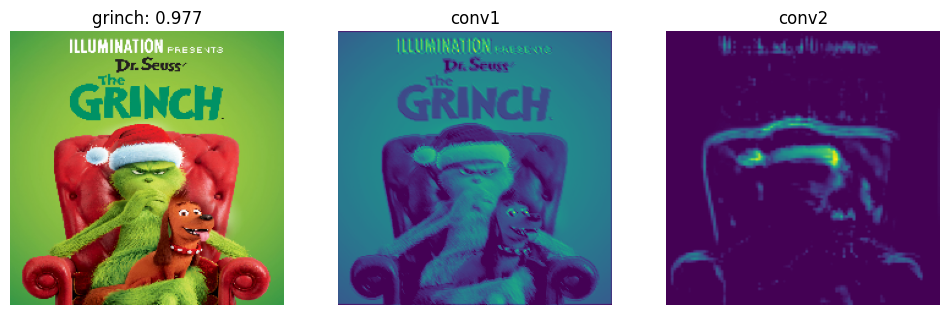

In [8]:
path = r"original_data\grinch\996e9861988631a0e2dd9ed5c71b24cf5a63c97b8fdbacf8adeac15eaf11ac53._RI_TTW_.jpg"
image_tensor = to_tensor(path)
predict_class, probas, y, z = predict(image_tensor, model)

plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(image_tensor.permute(1, 2, 0))
plt.title(f"{predict_class}: {probas[0].max():.3f}")
plt.axis(False)

plt.subplot(1, 3, 2)
plt.imshow(y[0, 0])
plt.title("conv1")
plt.axis(False)

plt.subplot(1, 3, 3)
plt.imshow(z[0, 0])
plt.title("conv2")
plt.axis(False)

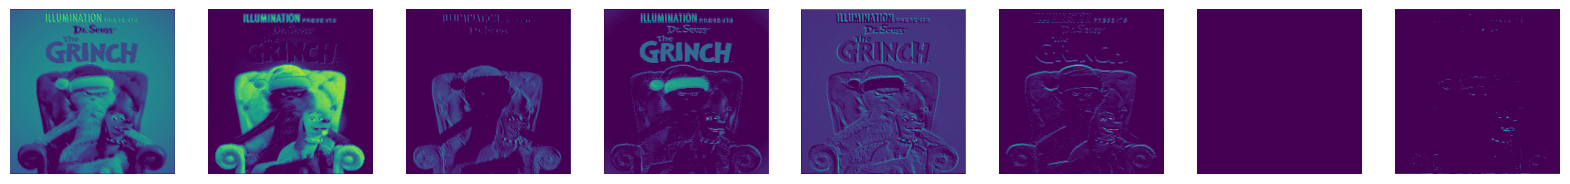

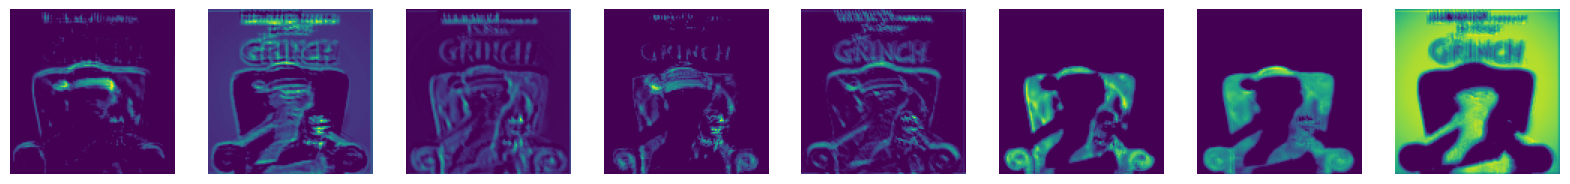

In [9]:
plt.figure(figsize=(20, 100))
for i, hidden in enumerate(y[0], start=1) :
    plt.subplot(2, 8, i)
    plt.imshow(hidden)
    plt.axis(False)

plt.figure(figsize=(20, 100))
for i, hidden in enumerate(z[0], start=1) :
    plt.subplot(2, 8, i)
    plt.imshow(hidden)
    plt.axis(False)

In [24]:
print(y[0][1])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


(-0.5, 123.5, 123.5, -0.5)

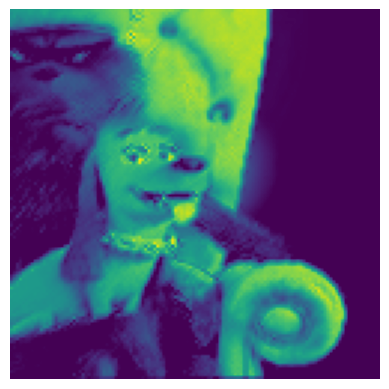

In [20]:
plt.imshow(y[0][1][100:, 100:])
plt.axis(False)